In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 200)

# import data

In [2]:
df_hist = pd.read_csv(r'.\csv\trapnet_biologicaldetailing_202302231329.csv', low_memory=False)
df_spec = pd.read_csv(r'.\csv\trapnet_specimen_202302231329.csv', low_memory=False)

# historical data without trivial fields (fields with only one entry)
unmatchable_hist = ['created_at', 'updated_at']
df_hist = df_hist.drop(unmatchable_hist, axis=1).loc[:, df_hist.nunique() > 1]
hist_sample_id_list = sorted(list(df_hist.sample_id.unique()))

# all species in historical data are 79 (atlantic salmon)
unmatchable_spec = ['created_at', 'updated_at', 'created_by_id', 'updated_by_id']
df_spec = df_spec[(df_spec.species_id==79) & (df_spec.sample_id.isin(hist_sample_id_list))].reset_index(drop=True)
df_spec = df_spec.drop(unmatchable_spec, axis=1).loc[:, df_spec.nunique() > 1]

# cast to int where appropriate
df_hist[['fork_length', 'sex_id']] = df_hist[['fork_length', 'sex_id']].astype('Int64')
df_spec[['fork_length', 'sex_id']] = df_spec[['fork_length', 'sex_id']].astype('Int64')

# archived fish data
df_arch = pd.read_csv(r'.\csv\fish_data.csv', low_memory=False)
df_arch['DATETIME'] = pd.to_datetime(df_arch['SITE_EVENT_DATE'].str.split(' ', expand=True)[0], format='%d/%m/%Y')
df_arch['old_id'] = 'GD_' + df_arch['GD_ID'].astype(str)
df_arch = df_arch[['old_id', 'DATETIME'] + [x for x in df_arch.columns if x not in ['SITE_EVENT_DATE', 'DATETIME', 'old_id']]]

In [3]:
# create a 'matching id' for matching distinctive fish characteristics

df_hist['matching_id'] = df_hist['sample_id'].astype(str) + df_hist['fork_length'].fillna(0).astype(str) + df_hist['weight'].fillna(0).astype(str) + df_hist['sex_id'].fillna(0).astype(str)
df_hist['matching_id'] = df_hist['matching_id'].str.replace('.', '_', regex=False)

df_spec['matching_id'] = df_spec['sample_id'].astype(str) + df_spec['fork_length'].fillna(0).astype(str) + df_spec['weight'].fillna(0).astype(str) + df_spec['sex_id'].fillna(0).astype(str)
df_spec['matching_id'] = df_spec['matching_id'].str.replace('.', '_', regex=False)

df_arch['arch_matching_id'] = '____' + df_arch['FORK_LENGTH'].fillna(0).round(0).astype('Int64').astype(str) + df_arch['WEIGHT'].fillna(0).astype(str) + df_arch['SEX'].fillna('U').map({'U':0,'M':1,'F':2}).astype(str)
df_arch['arch_matching_id'] = df_arch['arch_matching_id'].str.replace('.', '_', regex=False)

In [4]:
# combine historical and specimen data noting which sample they come from
#  start by assuming these are separate fish (no overlap), and confirm

all_fish = pd.concat([
    df_hist[['id', 'old_id', 'sample_id', 'matching_id']].rename({'id':'hist_id'}, axis=1),
    df_spec[['id', 'old_id', 'sample_id', 'matching_id']].rename({'id':'spec_id'}, axis=1)  # only samples that contain historical fishes are included in df_spec
], axis=0)[['old_id', 'spec_id', 'hist_id', 'sample_id', 'matching_id']]
all_fish.spec_id = all_fish.spec_id.astype('Int64')
all_fish.hist_id = all_fish.hist_id.astype('Int64')

# size of data
all_fish.shape

(102190, 5)

In [5]:
# merge with archived data

all_fish = pd.merge(all_fish, df_arch[['old_id', 'arch_matching_id']], on='old_id', how='left')

# check fish detail matches using matching id, and count the number of entries matching the archived data with spec & hist data
all_fish['fish_details_match'] = all_fish['matching_id'].str[4:] == all_fish['arch_matching_id'].str[4:]
all_fish['num_found_in_archive'] = all_fish[['spec_id', 'hist_id']].count(axis=1)

all_fish.head()

,old_id,spec_id,hist_id,sample_id,matching_id,arch_matching_id,fish_details_match,num_found_in_archive
0,GD_1,<NA>,69352,4390,4390340_51,____340_51,True,1
1,GD_2,<NA>,69353,4390,4390340_62,____340_62,True,1
2,GD_3,<NA>,69354,4390,4390360_51,____360_51,True,1
3,GD_4,<NA>,69355,4390,4390360_61,____360_61,True,1
4,GD_5,<NA>,69356,4390,4390361_31,____361_31,True,1


# is there overlap between df_spec and df_hist? (no)
# how many fish characteristics match between dm_apps and archived data? (all of them)
# do these fish have matching length, weight, sex? (yes, all of them)
# how many fish are matched in archive? (all of them)

In [6]:
all_fish.describe(percentiles=[])

,spec_id,hist_id,sample_id,num_found_in_archive
count,74666.000,27524.000,102190.000,102190.000
mean,2326088.809,83113.500,6511.726,1.000
std,74105.150,7945.639,1264.222,0.000
min,1708668.000,69352.000,4390.000,1.000
50%,2333117.500,83113.500,7193.000,1.000
max,2430212.000,96875.000,8001.000,1.000


In [7]:
# every single fish matches
all_fish.fish_details_match.value_counts()

True    102190
Name: fish_details_match, dtype: int64

In [8]:
# every single fish accounted for in archived data
sum(all_fish.arch_matching_id.isnull())

0

# does the number of duplicated fish in df_spec match the number of fish in df_hist? (no)
* ie, could the historical fish be part of the specimen fish that have used duplicated old_id? (CATCH_FREQUENCY > 1)

In [9]:
# most fish in df_spec are duplicates
df_spec.old_id.nunique()

18992

In [10]:
# every single fish in df_hist is a singleton
df_hist.old_id.nunique()

27524

In [11]:
# do the duplicates in df_spec account for df_hist?

df_grouped = all_fish.groupby(['sample_id', 'old_id']).count()
df_duplicates = df_grouped[df_grouped.spec_id>1].reset_index()
duplicated_fishes = list(df_duplicates.old_id)

df_duplicates.head()

,sample_id,old_id,spec_id,hist_id,matching_id,arch_matching_id,fish_details_match,num_found_in_archive
0,4404,GD_202,6,0,6,6,6,6
1,4404,GD_204,4,0,4,4,4,4
2,4404,GD_205,4,0,4,4,4,4
3,4404,GD_206,2,0,2,2,2,2
4,4404,GD_207,2,0,2,2,2,2


In [12]:
df_dupes_per_sample = df_duplicates.groupby('sample_id').count()[['old_id']].reset_index().rename({'old_id':'number_duplicates'}, axis=1).astype('Int64')
df_hist_per_sample = df_hist.groupby('sample_id').count()[['id']].reset_index().rename({'id':'number_historical'}, axis=1)
df_hist_v_dupes = pd.merge(df_dupes_per_sample, df_hist_per_sample, on='sample_id', how='outer')

df_hist_v_dupes.sample(10)

,sample_id,number_duplicates,number_historical
544,7686,9,38
517,7652,4,14
6,4412,7,10
650,7798,10,39
202,5302,6,30
245,5355,11,30
234,5344,37,28
71,4542,7,7
313,5585,20,69
339,5611,15,59


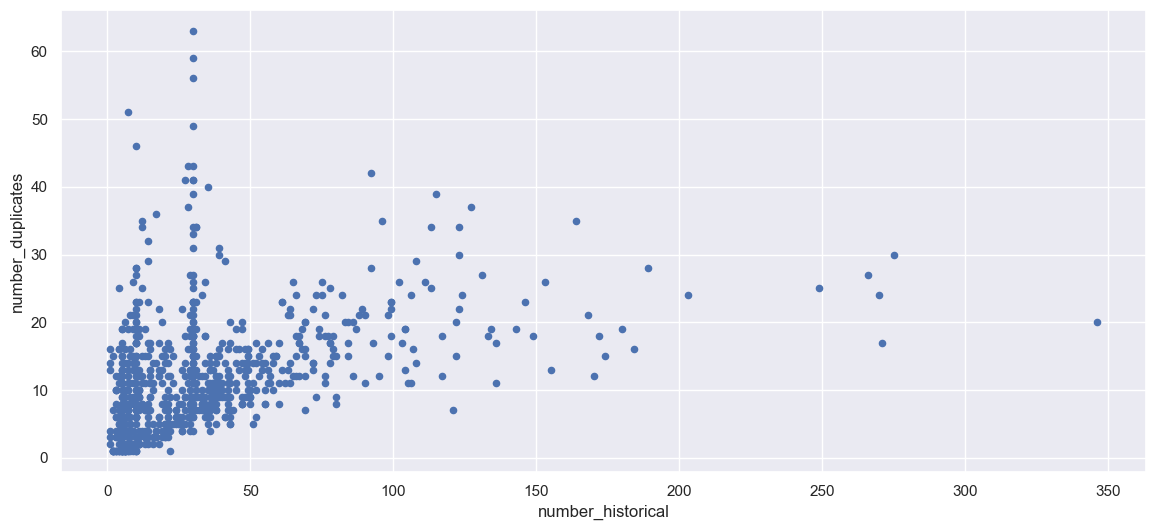

In [13]:
# historical and duplicated old_id do not look related

df_hist_v_dupes.plot(kind='scatter', x='number_historical', y='number_duplicates', figsize=(14, 6));

# does CATCH_FREQUENCY  from df_arch account for all duplicates? (yes)

In [14]:
df_catch_frequency = pd.merge(
    df_duplicates[['sample_id', 'old_id', 'spec_id']],
    df_arch[['old_id', 'CATCH_FREQUENCY']], 
    on='old_id',
    how='left'
)
df_catch_frequency.head()

,sample_id,old_id,spec_id,CATCH_FREQUENCY
0,4404,GD_202,6,6
1,4404,GD_204,4,4
2,4404,GD_205,4,4
3,4404,GD_206,2,2
4,4404,GD_207,2,2


In [15]:
# matches exactly
sum(df_catch_frequency.spec_id != df_catch_frequency.CATCH_FREQUENCY)

0

# is the catch frequency of df_hist always 1? (yes)

In [16]:
df_catch_frequency_historical = pd.merge(
    df_hist[['old_id']],
    df_arch[['old_id', 'CATCH_FREQUENCY']], 
    on='old_id',
    how='left'
)
df_catch_frequency_historical.head()

,old_id,CATCH_FREQUENCY
0,GD_1,1
1,GD_2,1
2,GD_3,1
3,GD_4,1
4,GD_5,1


In [17]:
# yes
sum(df_catch_frequency_historical.CATCH_FREQUENCY!=1)

0

# why are these data separated?
* SWEEP_NUMBER?
    # check a sample with notes 
    (the inclusion of notes is arbitrary, this is just where I found the evidence)
    * check to see where the divide between historical and specimen data is (SWEEP_NUMBER)

In [106]:
df_hist[df_hist.notes!='None']

,id,fork_length,total_length,weight,age_type,river_age,notes,old_id,life_stage_id,sample_id,sex_id,status_id,matching_id
410,69762,73,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3202,1,4479,2,4,4479730_02
413,69765,87,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3205,1,4479,2,4,4479870_02
415,69767,102,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3207,1,4479,2,4,44791020_02
416,69768,120,NaN,NaN,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_3208,1,4479,2,4,44791200_02
576,69928,95,NaN,NaN,1.000,1.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_4592,1,4512,2,4,4512950_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16938,86290,114,122.000,20.100,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_181620,1,7665,2,4,766511420_12
16939,86291,121,129.000,22.000,1.000,2.000,Field FISH _STATUS changed from RS to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,GD_181621,1,7665,1,4,766512122_01
26448,95800,47,NaN,NaN,2.000,0.000,"weight 0.28, probably wrong, removed",GD_200966,1,7929,<NA>,10,7929470_00
26452,95804,49,NaN,NaN,2.000,0.000,"weight 0.28, probably wrong, removed",GD_200970,1,7929,<NA>,10,7929490_00


In [138]:
# display(df_hist[df_hist.sample_id==7929][['old_id']+[x for x in df_hist.columns if x != 'old_id']].sort_values('old_id'))
# display(df_spec[df_spec.sample_id==7929][['old_id']+[x for x in df_spec.columns if x != 'old_id']].sort_values('old_id'))

In [131]:
# what is different starting after GD_201051

## SWEEP_NUMBER==0

df_arch[df_arch.old_id.isin(all_fish[all_fish.sample_id==7929].old_id.unique())][['old_id']+[x for x in df_arch.columns if x != 'old_id']].head(95).tail(10)

,old_id,DATETIME,SURVEY,SITE,CATCHMENT_NAME,CATCHMENT_INDEX,SURVEY_TYPE,SITE_EVENT_CODE,SWEEP_NUMBER,RECORD_IDENTIFIER,SPECIES_ITIS_CODE,SPECIES_LIFE_STAGE,ORIGIN,FISH_STATUS,FORK_LENGTH,FORK_LENGTH_INTERVAL_WIDTH,TOTAL_LENGTH,WEIGHT,WEIGHT_RESOLUTION,WEIGHT_PRECISION,FILE_TYPE,CATCH_FREQUENCY,FISH_SIZE,RIVER_AGE,AGE_TYPE,SEX,MATURITY,BIOLOGICAL_REMARKS,BIOLOGICAL_SAMPLE,SCALE_SAMPLE,SCALE_SAMPLE_ID,GD_ID,arch_matching_id
201046,GD_201047,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556726,161996,1731.000,W,RS,82.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201047,____820_00
201047,GD_201048,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556727,161996,1731.000,W,RS,83.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201048,____830_00
201048,GD_201049,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556728,161996,1731.000,W,RS,84.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201049,____840_00
201049,GD_201050,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556729,161996,1731.000,W,RS,85.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,1.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201050,____850_00
201050,GD_201051,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.000,8556730,161996,1731.000,W,RS,122.000,1.000,NaN,NaN,NaN,NaN,2.000,1,PARR,2.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201051,____1220_00
201052,GD_201053,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556922,161996,1731.000,W,RS,44.000,1.000,NaN,NaN,NaN,NaN,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201053,____440_00
201053,GD_201054,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556923,161996,1731.000,W,RS,44.000,1.000,NaN,NaN,NaN,NaN,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201054,____440_00
201054,GD_201055,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556924,161996,1731.000,W,RS,45.000,1.000,NaN,NaN,0.000,0.100,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,"weight 0.28, probably wrong, removed",1.000,NaN,NaN,201055,____450_00
201055,GD_201056,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556925,161996,1731.000,W,RS,46.000,1.000,NaN,NaN,0.000,0.100,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,"weight 0.28, probably wrong, removed",1.000,NaN,NaN,201056,____460_00
201056,GD_201057,1999-08-24,1999,29,RESTIGOUCHE,1,1,1,0.500,8556926,161996,1731.000,W,RS,46.000,1.000,NaN,NaN,NaN,NaN,2.000,1,FRY,0.000,LGTHFREQ,NaN,NaN,NaN,1.000,NaN,NaN,201057,____460_00


# is sweep number always non-zero for specimen? (almost yes)

In [134]:
df_arch[df_arch.old_id.isin(df_spec.old_id.unique())].SWEEP_NUMBER.value_counts()

1.000    6338
2.000    4522
3.000    3252
0.500    2150
4.000    2060
5.000     664
0.000       6
Name: SWEEP_NUMBER, dtype: int64

# is sweep number always zero for biological / historical? (yes)

In [135]:
df_arch[df_arch.old_id.isin(df_hist.old_id.unique())].SWEEP_NUMBER.value_counts()

0.000    27524
Name: SWEEP_NUMBER, dtype: int64

# let's check those 6 exceptions - sweep = 0 in specimen table
* CONFIRMED in SQL
* NOTE: for data without historical data, sweep_number=0 is much more common (from SQL)

In [137]:
df_arch[(df_arch.old_id.isin(df_spec.old_id.unique())) & (df_arch.SWEEP_NUMBER==0)]

,old_id,DATETIME,SURVEY,SITE,CATCHMENT_NAME,CATCHMENT_INDEX,SURVEY_TYPE,SITE_EVENT_CODE,SWEEP_NUMBER,RECORD_IDENTIFIER,SPECIES_ITIS_CODE,SPECIES_LIFE_STAGE,ORIGIN,FISH_STATUS,FORK_LENGTH,FORK_LENGTH_INTERVAL_WIDTH,TOTAL_LENGTH,WEIGHT,WEIGHT_RESOLUTION,WEIGHT_PRECISION,FILE_TYPE,CATCH_FREQUENCY,FISH_SIZE,RIVER_AGE,AGE_TYPE,SEX,MATURITY,BIOLOGICAL_REMARKS,BIOLOGICAL_SAMPLE,SCALE_SAMPLE,SCALE_SAMPLE_ID,GD_ID,arch_matching_id
2366,GD_2367,1971-09-08,1971,13,MIRAMICHI,2,1,1,0.000,8628334,161996,1731.000,W,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FRY,0.000,SCALE,M,NaN,NaN,1.000,NaN,NaN,2367,____00_01
2367,GD_2368,1971-09-08,1971,13,MIRAMICHI,2,1,1,0.000,8628335,161996,1731.000,W,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FRY,0.000,SCALE,M,NaN,NaN,1.000,NaN,NaN,2368,____00_01
3038,GD_3039,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626673,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,F,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3039,____00_02
3039,GD_3040,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626674,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,F,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3040,____00_02
3040,GD_3041,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626675,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,F,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3041,____00_02
3041,GD_3042,1971-07-27,1971,58,MIRAMICHI,2,1,1,0.000,8626676,161996,1731.000,W,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,PARR,1.000,SCALE,M,NaN,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,1.000,NaN,NaN,3042,____00_01


In [143]:
# sample ids
list(df_spec[df_spec.old_id.isin(df_arch[(df_arch.old_id.isin(df_spec.old_id.unique())) & (df_arch.SWEEP_NUMBER==0)].old_id)].sample_id.unique())

[4456, 4475]

In [144]:
# fish ids - these are all listed as sweep = 0.0
list(df_spec[df_spec.old_id.isin(df_arch[(df_arch.old_id.isin(df_spec.old_id.unique())) & (df_arch.SWEEP_NUMBER==0)].old_id)].id.unique())

[2230972, 2230973, 2233822, 2233823, 2233824, 2233825]

# differences between tables

In [53]:
# missing from specimen and in historical
[x for x in df_hist.columns if x not in df_spec.columns]

['total_length']

In [55]:
# missing from historical and in specimen
[x for x in df_spec.columns if x not in df_hist.columns]

['sweep_id', 'smart_river_age', 'smart_river_age_type']

In [59]:
# non-null total length data - could go into notes
sum(df_hist.total_length.notnull())

1663

In [100]:
# how does fork length compare to total length>?
(df_hist[df_hist.total_length.notnull()].total_length / df_hist[df_hist.total_length.notnull()].fork_length).describe()

count   1643.000
mean       1.067
std        0.019
min        0.966
25%        1.054
50%        1.067
75%        1.078
max        1.180
dtype: float64

# CONCLUSIONS:
* there is no overlap between the historical fish (BiologicalDetailing) and the specimen (Specimen) in dm_apps
    * ie, BiologicalDetailing and Specimen are mutually exclusive
* every single fish in the historical data is a singleton
    * ie, if imported from the historical table to the specimen table, no multiple fish are required
* all data is consistent with archived data
* historical data (BiologicalDetailing) appears to be specimen data with no sweep number
    * not sure if this was an import issue or a deliberate choice
    * cannot currently explain the 6/102,190 exceptions to this trend


# Check a few entries in dm_apps
* what I've checked looks correct

In [47]:
list_of_samples = list(df_hist.sample_id.unique())
rand_sample = np.random.choice(list_of_samples)

print('\n', f'http://127.0.0.1:8000/en/trapnet/samples/{rand_sample}/view/')

display(
    df_spec[df_spec.sample_id==rand_sample]
    .groupby('old_id')
    .count()[['id']]
    .rename({'id':'counts'}, axis=1)
    .sort_values('counts', ascending=False)
    .head()
)

display(all_fish[all_fish.sample_id==rand_sample])


 http://127.0.0.1:8000/en/trapnet/samples/5350/view/


,counts
old_id,
GD_38018,4
GD_38037,4
GD_38021,3
GD_38023,3
GD_38046,3


,old_id,spec_id,hist_id,sample_id,matching_id,arch_matching_id,fish_details_match,num_found_in_archive
3282,GD_37988,<NA>,72634,5350,5350390_60,____390_60,True,1
3283,GD_37989,<NA>,72635,5350,5350400_70,____400_70,True,1
3284,GD_37990,<NA>,72636,5350,5350410_70,____410_70,True,1
3285,GD_37991,<NA>,72637,5350,5350410_70,____410_70,True,1
3286,GD_37992,<NA>,72638,5350,5350410_70,____410_70,True,1
3287,GD_37993,<NA>,72639,5350,5350410_70,____410_70,True,1
3288,GD_37994,<NA>,72640,5350,5350420_70,____420_70,True,1
3289,GD_37995,<NA>,72641,5350,5350430_80,____430_80,True,1
3290,GD_37996,<NA>,72642,5350,5350430_80,____430_80,True,1
3291,GD_37997,<NA>,72643,5350,5350430_90,____430_90,True,1
